# Preproccesing

In [1]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=5475456973dd34db56f7192be9d3adaf351b6fcceb71181e365d8cf079345001
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pathlib import Path
from glob import glob
import os
from PIL import Image
import tensorflow as tf
from medmnist import BreastMNIST
from tensorflow import keras
from tensorflow.keras import layers
import random

In [3]:
train_data = BreastMNIST(split = 'train', download = True)
test_data = BreastMNIST(split = 'test', download = True)
val_data = BreastMNIST(split = 'val', download = True)

100%|██████████| 559580/559580 [00:01<00:00, 368059.53it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


[1]


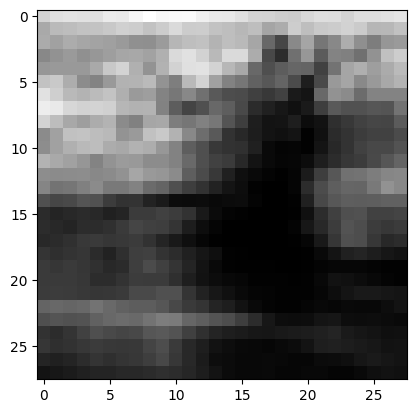

In [4]:
rand = random.randint(0,510)
plt.imshow(train_data.imgs[rand],cmap = 'gray')
print(train_data.labels[rand])

In [5]:
train_imgs = train_data.imgs
train_imgs = np.array(train_imgs)/255.
train_labels = train_data.labels


test_imgs = test_data.imgs
test_imgs = np.array(test_imgs)/255.
test_labels = test_data.labels

val_imgs = val_data.imgs
val_imgs = np.array(val_imgs)/255.
val_labels = val_data.labels

all_imgs = np.concatenate((train_imgs, test_imgs,val_imgs),0)
all_labels = np.concatenate((train_labels, test_labels, val_labels),0)

# tf
cat_train_labels = keras.utils.to_categorical(train_labels, 2)
train_imgs = np.reshape(train_imgs, (-1, 28, 28, 1))

In [6]:
img_size = 28
batch_size = 64

# CNN model

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Resizing(32,32),
  # tf.keras.layers.Rescaling(1/255)
])

In [8]:
base_model = tf.keras.applications.ResNet50(input_shape=(32,32,1),
                                               include_top=False,
                                               weights=None)

In [9]:
head_model = tf.keras.models.Sequential()
head_model.add(tf.keras.layers.GlobalAveragePooling2D())
head_model.add(tf.keras.layers.Dense(256, activation='elu'))
head_model.add(tf.keras.layers.Dropout(0.3))
head_model.add(tf.keras.layers.Dense(32, activation='elu'))
head_model.add(tf.keras.layers.Dropout(0.3))
head_model.add(tf.keras.layers.Dense(1 , activation='sigmoid'))


In [10]:
inputs = tf.keras.Input(shape=(28, 28, 1))
x = data_augmentation(inputs)
x = base_model(x)
outputs = head_model(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 1)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23581440  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 532801    
                                                                 
Total params: 24,114,241
Trainable params: 24,061,121
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy'])

batch_size = 32
epochs = 20
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6,
                              patience=1,
                              verbose=0, min_lr=1e-7)

In [ ]:
history = model.fit(train_imgs, train_labels,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (test_imgs, test_labels),
          callbacks=[reduce_lr])

Epoch 1/20
18/18 [==============================] - 65s 207ms/step - loss: 4.3175 - accuracy: 0.5842 - val_loss: 16554944102400.0000 - val_accuracy: 0.7308 - lr: 0.0100
Epoch 2/20
18/18 [==============================] - 1s 56ms/step - loss: 0.7706 - accuracy: 0.6722 - val_loss: 0.5836 - val_accuracy: 0.7308 - lr: 0.0100
Epoch 3/20
18/18 [==============================] - 1s 44ms/step - loss: 0.6531 - accuracy: 0.6941 - val_loss: 0.5833 - val_accuracy: 0.7308 - lr: 0.0060
Epoch 4/20
18/18 [==============================] - 1s 48ms/step - loss: 0.6522 - accuracy: 0.6832 - val_loss: 0.5836 - val_accuracy: 0.7308 - lr: 0.0036
Epoch 5/20
18/18 [==============================] - 1s 48ms/step - loss: 0.6560 - accuracy: 0.6722 - val_loss: 0.5837 - val_accuracy: 0.7308 - lr: 0.0022
Epoch 6/20
18/18 [==============================] - 1s 46ms/step - loss: 0.6312 - accuracy: 0.7015 - val_loss: 0.5842 - val_accuracy: 0.7308 - lr: 0.0013
Epoch 7/20
18/18 [==============================] - 1s 47ms/s

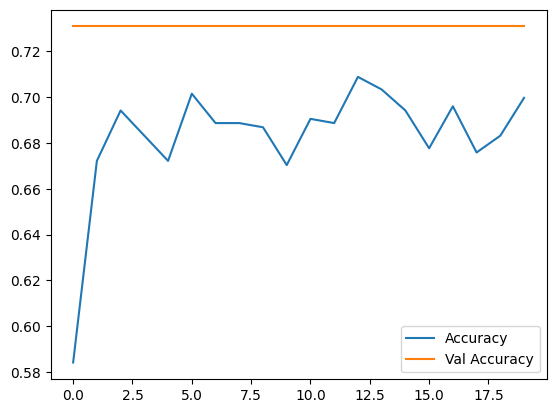

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Val Accuracy'])

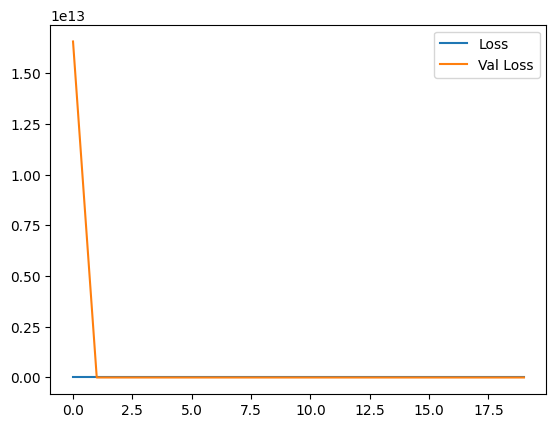

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val Loss'])

5/5 [==============================] - 1s 14ms/step
Accuracy is 0.7307692307692307
Presicion is 0.7307692307692307
F1 score is 0.8444444444444443


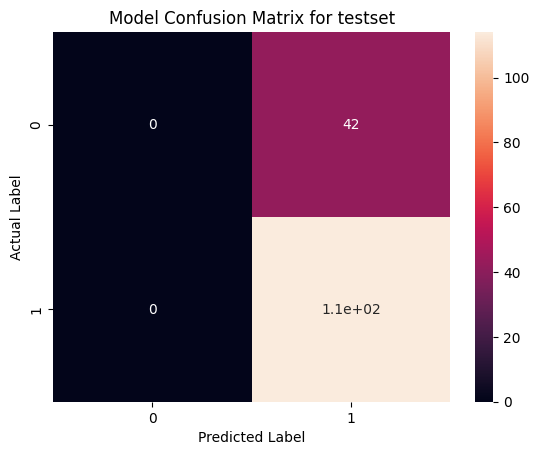

In [13]:
import numpy as np
y_predict = model.predict(test_imgs)
#We should use round because the model doesnt predict exact one or zero label.
#for example predicts 0.9999 for 1
y_predict=np.round(y_predict)
from sklearn.metrics import confusion_matrix
import seaborn as sns
model_cm=confusion_matrix(test_labels,y_predict)
sns.heatmap(model_cm, annot=True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Model Confusion Matrix for testset');
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix
Accuracy  = accuracy_score(test_labels, y_predict)
precision  = precision_score(test_labels, y_predict)
f1_Score = f1_score(test_labels, y_predict)
print(f'Accuracy is {Accuracy }')
print(f'Presicion is {precision }')
print(f'F1 score is {f1_Score}')

3/3 [==============================] - 1s 257ms/step
Accuracy is 0.7307692307692307
Presicion is 0.7307692307692307
F1 score is 0.8444444444444443


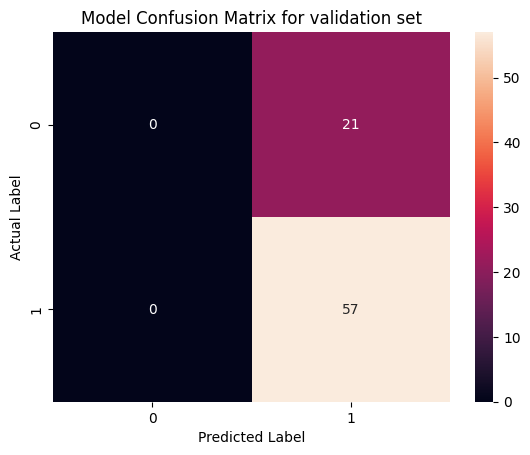

In [14]:
import numpy as np
y_predict = model.predict(val_imgs)
#We should use round because the model doesnt predict exact one or zero label.
#for example predicts 0.9999 for 1
y_predict=np.round(y_predict)
from sklearn.metrics import confusion_matrix
import seaborn as sns
model_cm=confusion_matrix(val_labels,y_predict)
sns.heatmap(model_cm, annot=True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Model Confusion Matrix for validation set');
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix
Accuracy  = accuracy_score(val_labels, y_predict)
precision  = precision_score(val_labels, y_predict)
f1_Score = f1_score(val_labels, y_predict)
print(f'Accuracy is {Accuracy }')
print(f'Presicion is {precision }')
print(f'F1 score is {f1_Score}')

# TF GAN

In [ ]:
batch_size = 64
num_channels = 1
num_classes = 2
image_size = 28
latent_dim = 128
LR = 0.00001

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

130 3


In [ ]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),],
      name="discriminator",
)

generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(7 * 7 * generator_in_channels),
        layers.ReLU(),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.ReLU(),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))


        batch_size = tf.shape(real_images)[0]
        z_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
        z_vector_labels = tf.concat([z_vector, one_hot_labels], axis=1)


        generated_images = self.generator(z_vector_labels)

        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )


        z_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
        z_vector_labels = tf.concat([z_vector, one_hot_labels], axis=1)

        fake_labels = tf.zeros((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator(z_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(fake_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),}


In [ ]:
cond_gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))

history = cond_gan.fit(train_imgs, cat_train_labels, epochs=2000, verbose = 0)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        1792      
                                                                 
 re_lu_5 (ReLU)              (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 re_lu_6 (ReLU)              (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d_1 (Glo  (None, 128)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                     

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6370)              834470    
                                                                 
 re_lu_7 (ReLU)              (None, 6370)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 130)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      266368    
 ranspose)                                                       
                                                                 
 re_lu_8 (ReLU)              (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

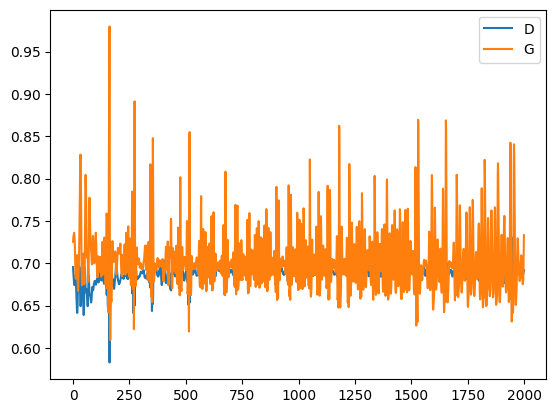

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.legend(['D','G'])

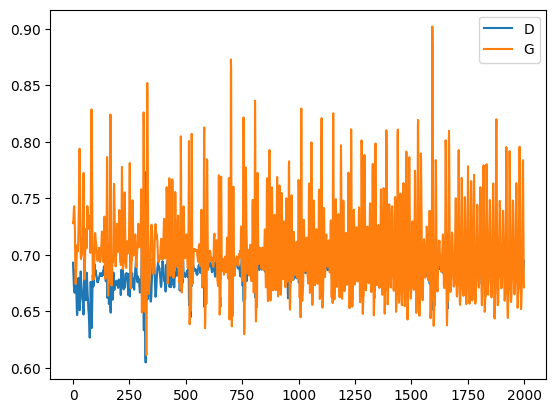

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.legend(['D','G'])

# Pytorch

## dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
transform = transforms.Compose([
                          transforms.ToTensor(),
                          # transforms.Normalize((0.5,), (0.5,))
                          ])
batch_size = 64

In [ ]:
class MedMNIST(Dataset):

    def __init__(self, transform=None, mode = 'all'):

      if mode == 'train':
        self.imgs = train_imgs
        self.labels = train_labels

      elif mode == 'test':
        self.imgs = test_imgs
        self.labels = test_labels

      elif mode == 'val':
        self.imgs = val_imgs
        self.labels = val_labels

      elif mode == 'all':
        self.imgs = all_imgs
        self.labels = all_labels

      self.transform = transform

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):

      img = self.imgs[idx]
      label = self.labels[idx]

      if self.transform:
          img = self.transform(img)

      return img, label

In [ ]:
dataset = MedMNIST(mode = 'train', transform = transform)
dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True,drop_last = True)

## model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
size_z = 200
n_channel = 2
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear = nn.Sequential(nn.Linear(size_z + n_channel, 7*7*128), nn.LeakyReLU())

        self.main = nn.Sequential(
            # 7,7
            nn.ConvTranspose2d(128, 20, kernel_size=5),  # 11, 11
            nn.BatchNorm2d(20),
            nn.ReLU(True),

            nn.ConvTranspose2d(20, 20, kernel_size=4),  # 14, 14
            nn.BatchNorm2d(20),
            nn.ReLU(True),

            nn.ConvTranspose2d(20, 20, kernel_size=4),  # 17, 17
            nn.BatchNorm2d(20),
            nn.ReLU(True),

            nn.ConvTranspose2d(20, 20, kernel_size=4),  # 20, 20
            nn.BatchNorm2d(20),
            nn.ReLU(True),

            nn.ConvTranspose2d(20, 20, kernel_size=4),  # 23, 23
            nn.BatchNorm2d(20),
            nn.ReLU(True),

            nn.ConvTranspose2d(20, 20, kernel_size=3),  # 25, 25
            nn.BatchNorm2d(20),
            nn.ReLU(True),

            nn.ConvTranspose2d(20, 1, kernel_size=4),  # 28, 28

             nn.Sigmoid()
        )

    def forward(self, input, label):
        input = torch.concat([input , label], dim=1)
        input = self.linear(input)

        input = input.view(input.size(0), 128, 7, 7)

        return self.main(input)


generator = Generator().to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear = nn.Sequential(nn.Linear(2, 7*7*16), nn.LeakyReLU())


        self.main = nn.Sequential(
            nn.Conv2d(2, 20, kernel_size=3), #26
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(20, 30, kernel_size=3), #24
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2),#12
            nn.Conv2d(30, 30, kernel_size=3), #10
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2), #5
            nn.Conv2d(30, 20, kernel_size=3), #3
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(20, 1, kernel_size=3), #1
            nn.Sigmoid()
        )
        self.flat = nn.Flatten()

    def forward(self, images, label):
        label = self.linear(label).view(label.size(0), 1, 28, 28)
        output = torch.concat([images, label], dim=1)
        output = self.main(output)
        output = self.flat(output)
        return output


disc = Discriminator().to(device)

In [ ]:
def train_discriminator(batch_data):
      real_inputs = batch_data[0].to(device)
      real_labels = batch_data[1].to(device)
      # print(real_labels)

      real_onehot_label = F.one_hot(torch.arange(2), 2)[real_labels.cpu().type(torch.LongTensor)].squeeze().to(device).float()
      real_outputs = disc(real_inputs, real_onehot_label)

      real_label = torch.ones(real_inputs.shape[0], 1).to(device)

      noise = (torch.rand(real_inputs.shape[0], size_z) - 0.5) / 0.5
      noise = noise.to(device)
      fake_inputs = generator(noise, real_onehot_label)
      # print(fake_inputs.shape)
      fake_outputs = disc(fake_inputs, real_onehot_label)
      fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

      outputs = torch.cat((real_outputs, fake_outputs), 0)
      targets = torch.cat((real_label, fake_label), 0)

      # Zero the parameter gradients
      disc.zero_grad()

      # Backward propagation
      d_loss = criterion(outputs, targets)
      d_loss.backward()
      optimizerD.step()
      return d_loss.item()

def train_generator(batch_data):
    real_inputs = batch_data[0].to(device)
    real_labels = batch_data[1].to(device)

    real_onehot_label = F.one_hot(torch.arange(2), 2)[real_labels.cpu().type(torch.LongTensor)].squeeze().to(device).float()

    noise = (torch.rand(real_inputs.shape[0], size_z)-0.5)/0.5
    noise = noise.to(device)

    fake_inputs = generator(noise, real_onehot_label)
    fake_outputs = disc(fake_inputs, real_onehot_label)

    targets = torch.ones([fake_outputs.shape[0], 1])
    targets = targets.to(device)

    g_loss = criterion(fake_outputs, targets)
    optimizerG.zero_grad()
    g_loss.backward()
    optimizerG.step()
    return g_loss.item(), fake_inputs, real_labels




In [ ]:
# We calculate Binary cross entropy loss
criterion = nn.BCELoss()
# Adam optimizer for generator
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.00001)
# Adam optimizer for discriminator
optimizerD = torch.optim.Adam(disc.parameters(), lr=0.00001)
epochs = 1000

In [ ]:
G_loss = []
D_loss = []
for epoch in range(0, epochs):
  # Training loop
  g_loss_epoch = 0
  d_loss_epoch = 0
  generator.train()
  disc.train()
  for batch, batch_data in enumerate(dataloader):
    d_loss = train_discriminator(batch_data)
    g_loss, fake_inputs, real_labels = train_generator(batch_data)

    d_loss_epoch += d_loss
    g_loss_epoch += g_loss

  d_loss_epoch = d_loss_epoch/(batch+1)
  g_loss_epoch = g_loss_epoch/(batch+1)
  G_loss.append(g_loss_epoch)
  D_loss.append(d_loss_epoch)


generator.eval();
disc.eval();

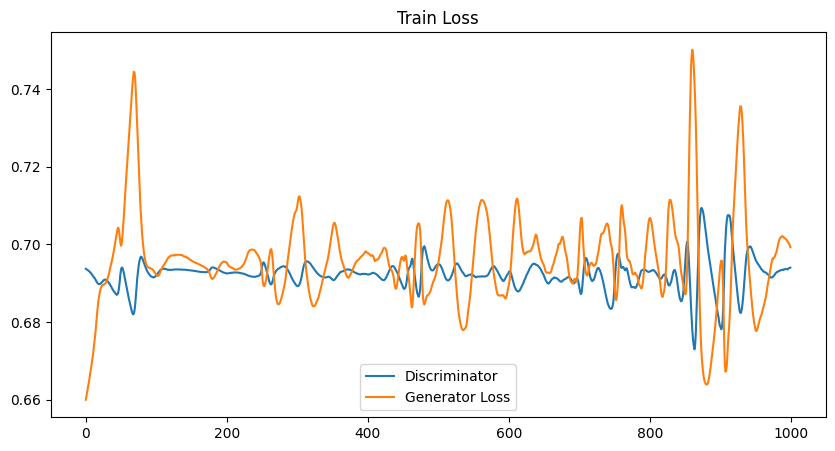

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Train Loss")
# plot Discriminator and generator loss
plt.plot(D_loss,label="D Loss")
plt.plot(G_loss,label="G Loss")
plt.legend(['Discriminator','Generator Loss'])

# Generating new data

In [ ]:
n_train = train_labels.shape[0]
n_ones = 399
n_zeros = int(n_train - n_ones)
n_new_samples_ones = int(500 - n_ones)
n_new_samples_zeros = int(500 - n_zeros)
size_z = 100

In [ ]:
#torch
# ones_label = torch.tensor([0., 1.]*n_new_samples_ones).to(device).reshape(n_new_samples_ones,2)
# zeros_label = torch.tensor([1., 0.]*n_new_samples_zeros).to(device).reshape(n_new_samples_zeros,2)
# z_input_ones = torch.randn(n_new_samples_ones, size_z).to(device)
# z_input_zeros = torch.randn(n_new_samples_zeros, size_z).to(device)
# generated_ones = generator(z_input_ones, ones_label).cpu().detach().squeeze().numpy()
# generated_zeros = generator(z_input_zeros, zeros_label).cpu().detach().squeeze().numpy()

In [ ]:
#tf
ones_noise = tf.random.normal(shape=(n_new_samples_ones, latent_dim))
ones_label = tf.reshape(tf.Variable([0., 1.]*n_new_samples_ones, dtype = float),(-1,2))
ones_noise_and_labels = tf.concat([ones_noise, ones_label], 1)

zeros_noise = tf.random.normal(shape=(n_new_samples_zeros, latent_dim))
zeros_label = tf.reshape(tf.Variable([1., 0.]*n_new_samples_zeros, dtype = float),(-1,2))
zeros_noise_and_labels = tf.concat([zeros_noise, zeros_label], 1)

generated_ones = cond_gan.generator.predict(ones_noise_and_labels, verbose = 0)
generated_zeros =  cond_gan.generator.predict(zeros_noise_and_labels, verbose = 0)

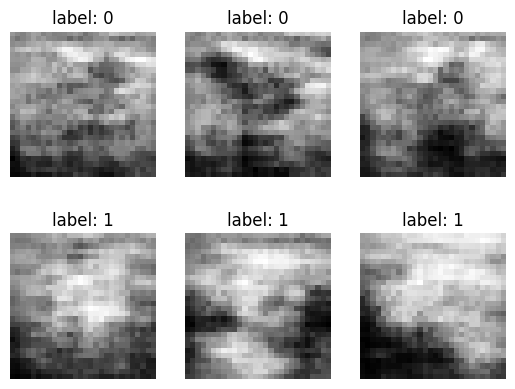

In [ ]:
# plt.figure(figsize = (7,15))
for i in range(3):
  plt.subplot(2, 3, i+1)
  plt.imshow(generated_zeros[i], cmap = 'gray')
  plt.title('label: 0')
  plt.axis('off')
  plt.subplot(2, 3, i+4)
  plt.imshow(generated_ones[i], cmap = 'gray')
  plt.title('label: 1')
  plt.axis('off')


In [ ]:
new_ones_label = np.ones((n_new_samples_ones,1), dtype='uint8')
new_zeros_label = np.zeros((n_new_samples_zeros,1), dtype='uint8')

In [ ]:
new_train_imgs =  tf.concat((train_imgs, generated_ones,generated_zeros),0)
new_train_labels =  tf.concat((train_labels, new_ones_label, new_zeros_label),0)

In [ ]:
new_dataset_size = 1000

In [ ]:
tf.random.set_seed(1380)
new_train_imgs = tf.random.shuffle(new_train_imgs)[:new_dataset_size]
tf.random.set_seed(1380)
new_train_labels = tf.random.shuffle(new_train_labels)[:new_dataset_size]

# CNN model with generated data

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Resizing(32,32)
])

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(32,32,1),
                                               include_top=False,
                                               weights=None)

In [ ]:
head_model = tf.keras.models.Sequential()
head_model.add(tf.keras.layers.GlobalAveragePooling2D())
head_model.add(tf.keras.layers.Dense(256, activation='elu'))
head_model.add(tf.keras.layers.Dropout(0.3))
head_model.add(tf.keras.layers.Dense(32, activation='elu'))
head_model.add(tf.keras.layers.BatchNormalization())
head_model.add(tf.keras.layers.Dropout(0.3))
head_model.add(tf.keras.layers.Dense(1 , activation='sigmoid'))


In [ ]:
inputs = tf.keras.Input(shape=(28, 28, 1))
x = data_augmentation(inputs)
x = base_model(x)
outputs = head_model(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 1)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23581440  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 532929    
                                                                 
Total params: 24,114,369
Trainable params: 24,061,185
Non-trainable params: 53,184
_________________________________________________________________


In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])

batch_size = 32
epochs = 50
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.6,
                              patience=1,
                              verbose=0, min_lr=1e-7)

In [ ]:
history = model.fit(new_train_imgs, new_train_labels,
          batch_size = batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (test_imgs, test_labels),
          callbacks=[reduce_lr])

Epoch 1/50
32/32 [==============================] - 43s 80ms/step - loss: 0.2447 - accuracy: 0.9200 - val_loss: 795.5356 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 1s 42ms/step - loss: 0.2788 - accuracy: 0.8970 - val_loss: 67.5448 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 1s 43ms/step - loss: 0.1986 - accuracy: 0.9250 - val_loss: 3.0152 - val_accuracy: 0.7564 - lr: 6.0000e-04
Epoch 4/50
32/32 [==============================] - 1s 45ms/step - loss: 0.0961 - accuracy: 0.9640 - val_loss: 1.3023 - val_accuracy: 0.7372 - lr: 6.0000e-04
Epoch 5/50
32/32 [==============================] - 1s 44ms/step - loss: 0.0884 - accuracy: 0.9730 - val_loss: 1.0680 - val_accuracy: 0.7692 - lr: 3.6000e-04
Epoch 6/50
32/32 [==============================] - 2s 57ms/step - loss: 0.0630 - accuracy: 0.9840 - val_loss: 0.9415 - val_accuracy: 0.7756 - lr: 3.6000e-04
Epoch 7/50
32/32 [==============================] - 2s 5

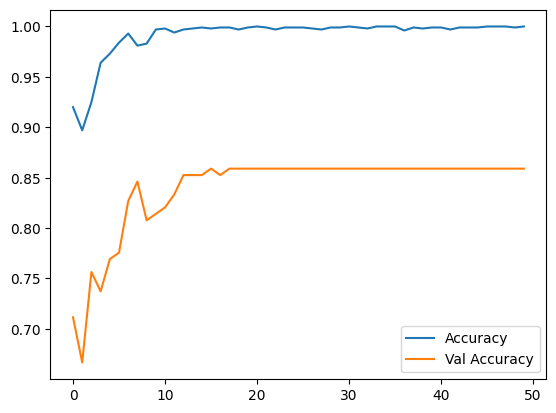

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Val Accuracy'])

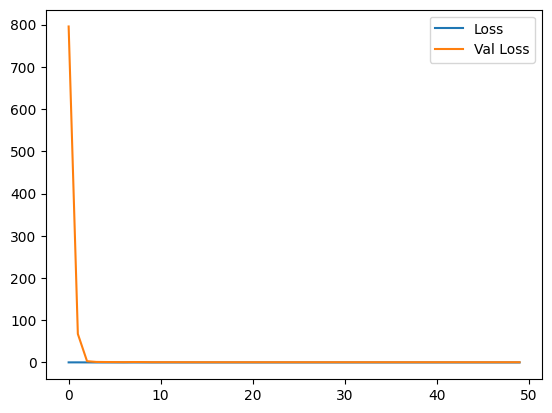

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val Loss'])

5/5 [==============================] - 1s 17ms/step
Accuracy is 0.8589743589743589
Presicion is 0.8833333333333333
F1 score is 0.905982905982906


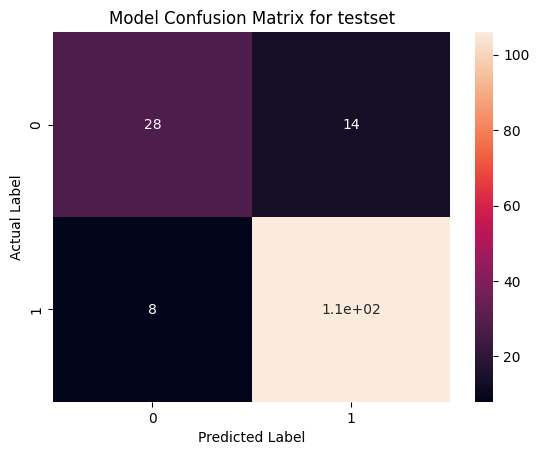

In [ ]:
import numpy as np
y_predict = model.predict(test_imgs)
#We should use round because the model doesnt predict exact one or zero label.
#for example predicts 0.9999 for 1
y_predict=np.round(y_predict)
from sklearn.metrics import confusion_matrix
import seaborn as sns
model_cm=confusion_matrix(test_labels,y_predict)
sns.heatmap(model_cm, annot=True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Model Confusion Matrix for testset');
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix
Accuracy  = accuracy_score(test_labels, y_predict)
precision  = precision_score(test_labels, y_predict)
f1_Score = f1_score(test_labels, y_predict)
print(f'Accuracy is {Accuracy }')
print(f'Presicion is {precision }')
print(f'F1 score is {f1_Score}')

3/3 [==============================] - 0s 16ms/step
Accuracy is 0.8589743589743589
Presicion is 0.9107142857142857
F1 score is 0.9026548672566371


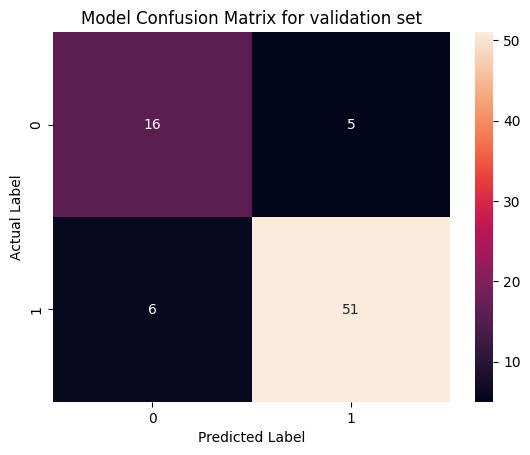

In [ ]:
import numpy as np
y_predict = model.predict(val_imgs)
#We should use round because the model doesnt predict exact one or zero label.
#for example predicts 0.9999 for 1
y_predict=np.round(y_predict)
from sklearn.metrics import confusion_matrix
import seaborn as sns
model_cm=confusion_matrix(val_labels,y_predict)
sns.heatmap(model_cm, annot=True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Model Confusion Matrix for validation set');
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix
Accuracy  = accuracy_score(val_labels, y_predict)
precision  = precision_score(val_labels, y_predict)
f1_Score = f1_score(val_labels, y_predict)
print(f'Accuracy is {Accuracy }')
print(f'Presicion is {precision }')
print(f'F1 score is {f1_Score}')